# 차선 검출

### import

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Sobel Gradients 적용

In [2]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

### Gradient Magnitude 적용

In [3]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the xy magnitude 
    mag = np.sqrt(x**2 + y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1 
    return binary_output

### Gradient Direction 적용

In [4]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

### HSL Channel 적용

In [5]:
def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convert to HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

### Red Channel 적용

In [6]:
def red_select(img, thresh=(0, 255)):
    # Apply a threshold to the R channel
    R = img[:,:,0]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

### Binary Pipeline 

In [7]:
def binary_pipeline(img):    
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    
    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    #red_binary = red_select(img_copy, thresh=(200,255))
    
    # Sobel x
    x_binary = abs_sobel_thresh(img_copy,thresh=(25, 200))
    y_binary = abs_sobel_thresh(img_copy,thresh=(25, 200), orient='y')
    xy = cv.bitwise_and(x_binary, y_binary)
    
    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    
    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    final_binary = cv.bitwise_or(s_binary, gradient)
    
    return final_binary

### 차선 ROI 영역 Warp Image

In [8]:
def warp_image(img):    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #운전자 시야 영역 지정
    source_points = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])
    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    
    inverse_perspective_transform = cv.getPerspectiveTransform(destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
       
    return warped_img, inverse_perspective_transform

### 도로 차선 검출

In [9]:
def track_lanes_initialize(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half 
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit, out_img

### 이차 다항식 출력을 얻는 함수

In [10]:
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

### 지정된 영역을 fillPoly를 통해 선으로 표시 후 해당 영역을 역투영하여 반환하는 함수

In [11]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):    
    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane 
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    return result

### 곡선 측정

In [12]:
def measure_curve(binary_warped,left_fit,right_fit):        
    # generate y values 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car 
    y_eval = np.max(ploty)
    
    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

### 차량 오프셋

In [13]:
def vehicle_offset(img,left_fit,right_fit):    
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    
    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    
    ## vehicle offset
    distance = image_center - lane_center
    
    ## convert to metric
    return (round(distance*xm_per_pix,5))

### test image 를 binary image로 변환

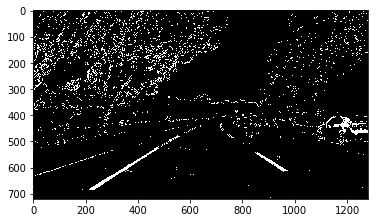

In [14]:
global curve_radius
global offset
global inverse_perspective_transform

img = mpimg.imread('test5.jpg')

# get binary image
binary_img = binary_pipeline(img)

plt.imshow(binary_img, cmap='gray')

### perspective transform

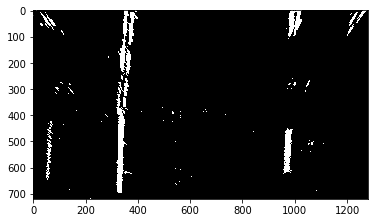

In [15]:
birdseye, inverse_perspective_transform = warp_image(binary_img)

plt.imshow(birdseye, cmap='gray')

### 차선 검출

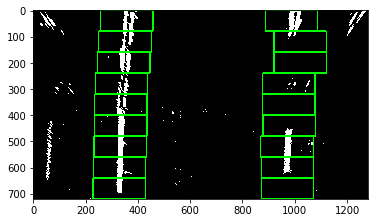

In [16]:
left_fit, right_fit, out_img = track_lanes_initialize(birdseye)

plt.imshow(out_img)

### draw polygon

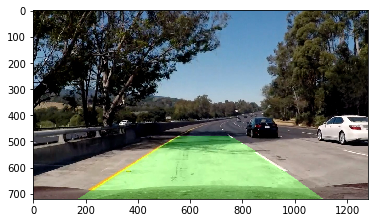

In [17]:
processed_frame = lane_fill_poly(birdseye, img, left_fit, right_fit)

plt.imshow(processed_frame)

### radius, offset 측정

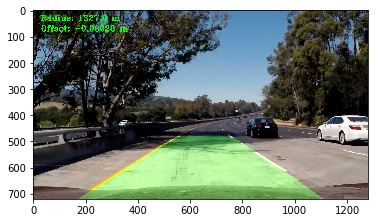

In [18]:
#measure radius
curve_radius = measure_curve(birdseye,left_fit,right_fit)
#measure offset
offset = vehicle_offset(img, left_fit, right_fit)

font = cv.FONT_HERSHEY_TRIPLEX
processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
processed_frame = cv.putText(processed_frame, 'Offset: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)
   
plt.imshow(processed_frame)